In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd


import sys

sys.path.insert(0, '../../../quetzal/')

from quetzal.model import stepmodel

from syspy.spatial import spatial
from syspy.skims import skims

SQLalchemy is not installed. No support for SQL output.


In [2]:
municipios = [
    'los alcarrizos',
    'santo domingo oeste', 
    'santo domingo norte', 
    'santo domingo este',
    'santo domingo de guzman'
]

In [3]:
work_path = r'../../'
data_path = work_path + 'inputs/data/'
quetzal_path = work_path 
zones =  gpd.read_file(work_path + r'inputs/zones/zones_admin.shp').set_index('desc')
zones = zones.loc[zones['municipio'].isin(municipios)]
zones = zones.loc[zones['muestra']> 0]
zones.index = 'zone_' + zones['id'].astype(str)

<AxesSubplot:>

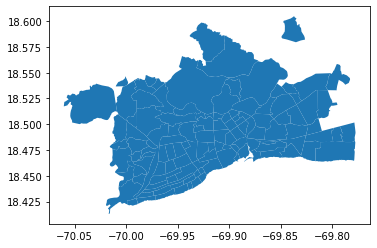

In [4]:
%matplotlib inline
zones.plot()

In [5]:
zones['growth'] = zones['provincia'].apply(
    lambda p: {
        'distrito nacional': 1.006,
        'santo domingo': 1.016
    }[p]
)

ref_year = 2018
for year in range(2018, 2100):
    for segment in ['pop']:
        delta = year - ref_year
        zones[segment + str(year)] = (zones[segment]  * np.power(zones['growth'], delta)  ).astype(int)

In [6]:
euclidean = skims.euclidean(zones)
intrazonal = 0.8
euclidean['km'] = np.round((euclidean['euclidean_distance'] / 1000 + intrazonal) )

In [7]:
desplazamiento = pd.read_csv(data_path + 'desplazamientos_dispo_carro.csv', encoding='latin', sep=';')

In [8]:
desplazamiento = desplazamiento.dropna(subset=['zona_origen', 'zona_destino'])
desplazamiento['origin'] = desplazamiento['zona_origen'].apply(lambda z: 'zone_' +  z.split('.')[0])
desplazamiento['destination'] = desplazamiento['zona_destino'].apply(lambda z: 'zone_' +  z.split('.')[0])
desplazamiento = pd.merge(
    desplazamiento,
    euclidean,
    left_on=['origin', 'destination'], #['zona_origen', 'zona_destino'],
    right_on=['origin', 'destination'],
    how='left'
)

desplazamiento['acceso_bool'] = desplazamiento['acceso'].replace(float('inf'), 0).fillna(0).astype(bool).astype(int)
muestra = pd.merge(desplazamiento, zones['muestra'].reset_index(), left_on='origin', right_on='id')
motorizacion =  muestra.groupby('muestra')['acceso_bool'].mean().to_dict()

In [9]:
ppm = desplazamiento.loc[desplazamiento['hora_militar'].isin([6, 7, 8, 9])]

In [10]:
weights = desplazamiento.groupby(['hora_militar'])['peso_individual'].sum()

In [11]:
hpm = weights[7] / 2 + weights[6] / 4 + weights[8] / 4
ppm = weights[[6, 7, 8, 9]].sum()

In [12]:
hpm / ppm

0.34401454717780444

In [13]:
hpm / weights.sum()

0.1098120176797418

# acceso carro

<AxesSubplot:>

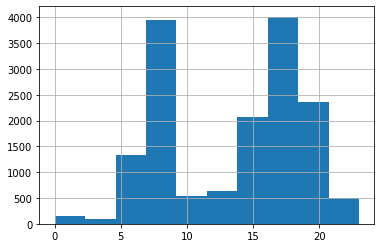

In [14]:
desplazamiento['hora_militar'].hist()

In [15]:
#desplazamiento = desplazamiento.loc[desplazamiento['hora_militar'].isin([17, 18, 19])]
desplazamiento = desplazamiento.loc[desplazamiento['hora_militar'].isin([6, 7, 8, 9])]
desplazamiento = desplazamiento.loc[desplazamiento['hora_militar']> 0]

In [16]:
%matplotlib inline

<AxesSubplot:>

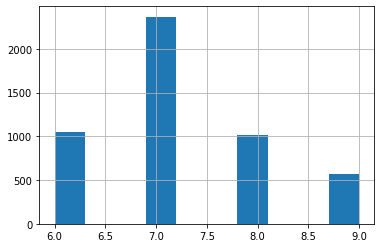

In [17]:
desplazamiento['hora_militar'].hist()

<AxesSubplot:>

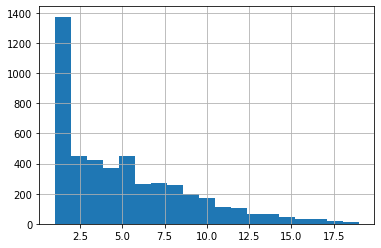

In [18]:
desplazamiento = desplazamiento.loc[desplazamiento['km'] < 20]
#desplazamiento = desplazamiento.loc[desplazamiento['euclidean_distance']> 0]
desplazamiento['km'].hist(bins=19)

In [19]:
np.average(desplazamiento['km'], weights=desplazamiento['peso_individual'])

4.807343937522829

In [20]:
desplazamiento.groupby(['modo'])['km'].mean()

modo
a_pie    1.512148
carro    5.434412
pt       6.113237
Name: km, dtype: float64

In [21]:
desplazamiento.groupby(['motivo'])['km'].mean()

motivo
Domicilio              3.539249
Estudiar               3.122739
Hacer trámites         5.543103
Ir de compras          2.968750
Otro                   5.606557
Paseo / Ocio           4.781250
Trabajar               5.457742
acompañar a alguien    3.432692
Name: km, dtype: float64

In [22]:
desplazamiento['motorizado'] = desplazamiento['acceso'].astype(bool)
desplazamiento.groupby(['motorizado'])['km'].mean()

motorizado
False    4.614286
True     5.064996
Name: km, dtype: float64

In [23]:
len(desplazamiento)

4724

<AxesSubplot:xlabel='km'>

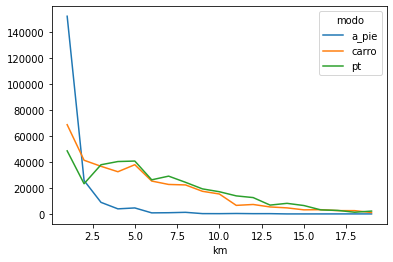

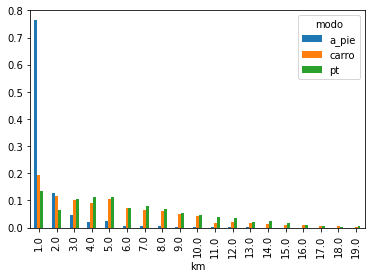

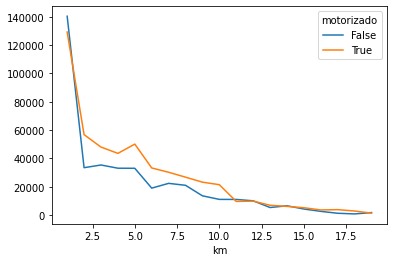

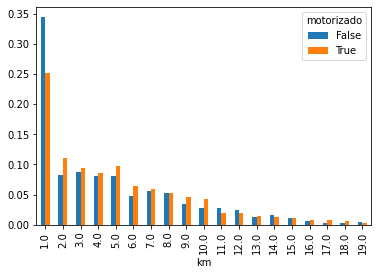

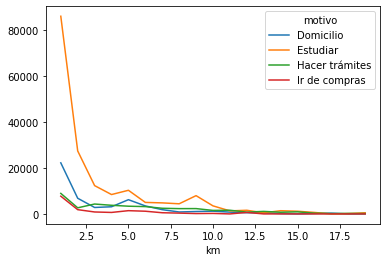

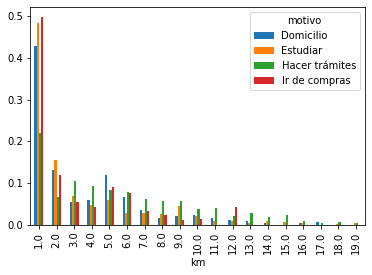

In [24]:
mat = desplazamiento.groupby(['km','modo'])['peso_individual'].sum().unstack().fillna(0)
mat.plot()
(mat / mat.sum()).plot(kind='bar')

mat = desplazamiento.groupby(['km','motorizado'])['peso_individual'].sum().unstack().fillna(0)
mat.plot()
(mat / mat.sum()).plot(kind='bar')

mat = desplazamiento.groupby(['km','motivo'])['peso_individual'].sum().unstack().fillna(0).iloc[:, :4]
mat.plot()
(mat / mat.sum()).plot(kind='bar')

In [25]:
grouped = desplazamiento.groupby(['origin', 'destination'])
od = grouped['peso_individual'].sum().fillna(0).astype(int).reset_index()
#od['origin'] = od['zona_origen']#.apply(lambda s: int(s.split('.')[0]))
#od['destination'] = od['zona_destino']#.apply(lambda s: int(s.split('.')[0]))

In [26]:
grouped = desplazamiento.groupby(['modo','origin', 'destination'])
mod = grouped['peso_individual'].sum().fillna(0).astype(int).reset_index()

In [27]:
emission = od.groupby(['origin'])['peso_individual'].sum()
attraction = od.groupby(['destination'])['peso_individual'].sum()

In [28]:
zones['emission'] = emission
zones['attraction'] = attraction
zones['emission_d'] = zones['emission'] / zones['geometry'].apply(lambda g: g.area)
zones['attraction_d'] = zones['attraction'] / zones['geometry'].apply(lambda g: g.area)

In [29]:
from imp import reload
reload(stepmodel)
from quetzal.engine import engine
reload(engine)
sm = stepmodel.StepModel()

In [30]:
zones = zones.fillna(0)
sm.zones = zones.sort_index()

In [31]:
sm.zones = sm.zones.loc[sm.zones['region'] == 'region ozama o metropolitana']

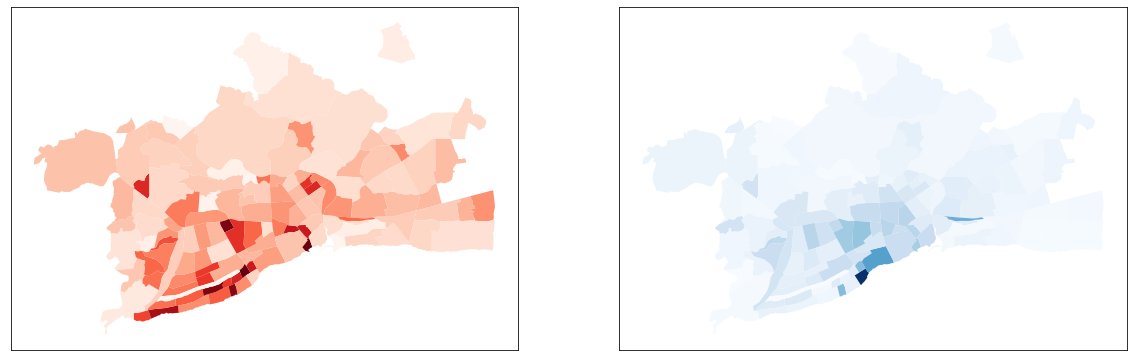

In [32]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(ncols=2, figsize=[20, 10])
sm.plot('zones', column='emission_d', alpha=1, figsize=[10, 5], cmap='Reds', ax=ax[0])
sm.plot('zones', column='attraction_d', alpha=1, figsize=[10, 5], cmap='Blues', ax=ax[1])
for a in ax:
    a.set_aspect('equal')
    a.set_yticks([])
    a.set_xticks([])

<AxesSubplot:>

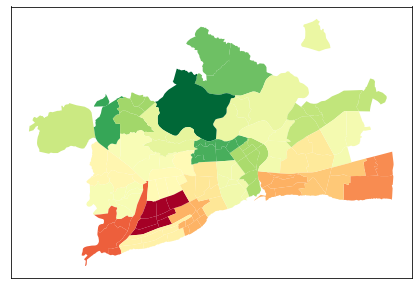

In [33]:
sm.zones['motorizacion'] = np.round(sm.zones['muestra'].apply(lambda m: motorizacion[m]), 3)
sm.plot('zones', column='motorizacion', alpha=1, figsize=[10, 5], cmap='RdYlGn_r')

<AxesSubplot:xlabel='emission', ylabel='attraction'>

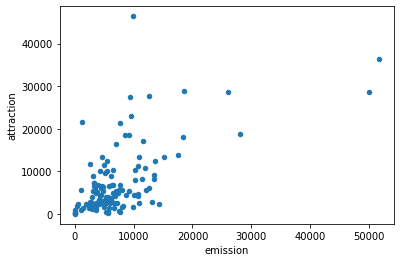

In [34]:
pd.DataFrame(zones).plot(kind='scatter', x='emission',y='attraction')

In [35]:
od['volume'] = od['peso_individual'].fillna(0)

In [36]:
from tqdm import tqdm

In [37]:
import geopandas as gpd
gdf = gpd.GeoDataFrame(sm.zones)

In [38]:
gdf.crs = {'init' :'epsg:4326'}
meters = gdf.to_crs({'init': 'epsg:32619'})
intra_dict = np.sqrt(meters.area).to_dict()

In [39]:
euclidean['origin_size'] = euclidean['origin'].apply(lambda o: intra_dict[o] / 1000)

In [40]:
l = []
for intrazonal in tqdm([i / 10 for i in range(5, 15)]):
    for power in [1+i /10 for i in range(5, 15) ]:
        e = euclidean.copy()
        e.loc[e['origin'] == e['destination'], 'km'] = e.loc[e['origin'] == e['destination'], 'origin_size'] * intrazonal
        #e.loc[e['km'] > 20, 'km'] = 1e9
        impedance = np.power(
            e.set_index(['origin', 'destination']).sort_index().unstack('destination')['km'],
            -power
        )
        sm.step_distribution(
            deterrence_matrix=impedance,
        )
        merged = pd.merge(euclidean, sm.volumes, on=['origin', 'destination'])
        dist = np.average(merged['km'], weights=merged['volume'])
        m = merged.copy()
        d = desplazamiento.copy()
        intra_ratio = m.loc[m['origin'] == m['destination']]['volume'].sum() / m['volume'].sum()
        
        left = pd.merge(sm.volumes, od, on=['origin', 'destination'], suffixes=['_distribution', '_control'], how='outer')
        merged = pd.merge(left, euclidean, on=['origin', 'destination'])
        grouped = merged.groupby('km')[['volume_distribution', 'volume_control']].sum()
        grouped['delta'] = grouped['volume_control'].fillna(0) - grouped['volume_distribution'].fillna(0)
        grouped['earth'] = grouped['delta'].cumsum()
        earth = np.abs(grouped['earth']).sum()

        l.append([intrazonal, power, dist, intra_ratio, earth])

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.49it/s]


In [41]:
d = desplazamiento.copy()

intra_ratio = d.loc[d['origin'] == d['destination']]['peso_individual'].sum() / d['peso_individual'].sum()
dist = np.average(desplazamiento['km'], weights=desplazamiento['peso_individual'])
df = pd.DataFrame(l, columns=['intrazonal', 'power', 'dist', 'intra_ratio', 'earth'])
df['dist'] /= dist
df['intra_ratio'] /= intra_ratio
df['earth'] = np.round(df['earth'], -3).astype(int)
df['score'] = ((np.abs(df['dist'] - 1) + np.abs(df['intra_ratio'] - 1) )* 100).astype(int)
intrazonal, power = df.sort_values('score')[['intrazonal', 'power']].iloc[0]

In [42]:
df.sort_values('score')

,intrazonal,power,dist,intra_ratio,earth,score
16,0.6,2.1,0.971053,1.005418,159000,3
4,0.5,1.9,1.002509,1.030202,108000,3
28,0.7,2.3,0.944725,0.970033,267000,8
15,0.6,2.0,1.010869,0.925144,88000,8
27,0.7,2.2,0.978189,0.902647,172000,11
...,...,...,...,...,...,...
81,1.3,1.6,1.333220,0.232612,1474000,110
70,1.2,1.5,1.364822,0.237823,1613000,112
91,1.4,1.6,1.341690,0.209997,1511000,113
80,1.3,1.5,1.373879,0.214432,1653000,115


In [43]:
intrazonal, power = 0.8, 1.8
intrazonal, power = 0.7, 1.7
intrazonal, power = 0.9, 2
intrazonal, power = 0.7, 1.7
intrazonal, power = 1, 2
intrazonal, power = 0.6, 2

print(intrazonal, power)
e = euclidean.copy()
e.loc[e['origin'] == e['destination'], 'km'] = e.loc[e['origin'] == e['destination'], 'origin_size'] * intrazonal
e.loc[e['km'] > 20, 'km'] = 1e9
impedance = np.power(
    e.set_index(['origin', 'destination']).sort_index().unstack('destination')['km'],
    -power
)
sm.step_distribution(
    deterrence_matrix=impedance,
)

left = pd.merge(sm.volumes, od, on=['origin', 'destination'], suffixes=['_distribution', '_control'], how='outer')
merged = pd.merge(left, euclidean, on=['origin', 'destination'])
grouped = merged.groupby('km')[['volume_distribution', 'volume_control']].sum()
grouped['delta'] = grouped['volume_control'].fillna(0) - grouped['volume_distribution'].fillna(0)
grouped['earth'] = grouped['delta'].cumsum()
earth = np.abs(grouped['earth']).sum()

0.6 2


In [44]:
desplazamiento.columns

Index(['zona_destino', 'motivo', 'modo_1', 'modo_2', 'modo_3', 'modo_4',
       'modo_5', 'costo', 'duracion', 'hora', 'am_pm', 'mas_desplazamiento',
       'numero_desplazamiento', 'individual_id', 'zona_hogar',
       'peso_individual', 'zona_origen', 'count', 'modos', 'pt', 'modo',
       'modo_principal', 'minutos', 'minutos_duracion', 'minutos_inferred',
       'random', 'minutos_random', 'hora_militar', 'acceso', 'origin',
       'destination', 'euclidean_distance', 'x_origin', 'y_origin',
       'x_destination', 'y_destination', 'km', 'acceso_bool', 'motorizado'],
      dtype='object')

<AxesSubplot:xlabel='km'>

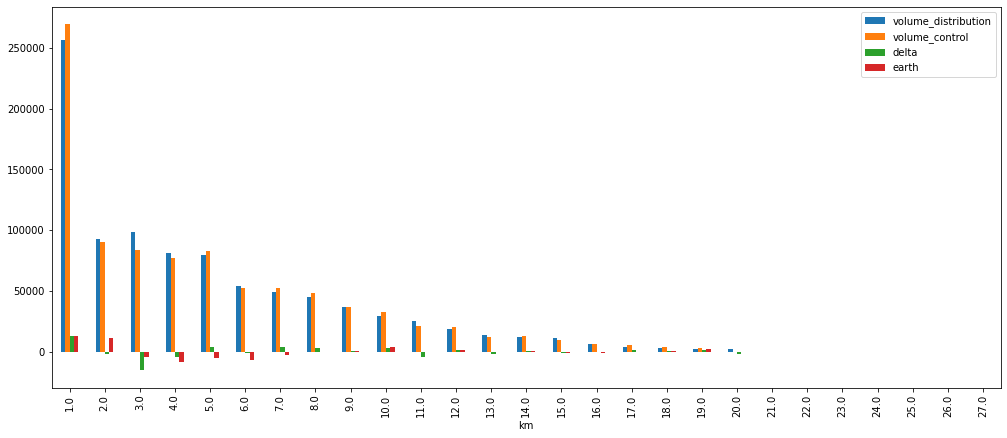

In [45]:
grouped.plot(kind='bar', figsize=[17, 7])

In [46]:
od['volume_ref'] = od['volume']

In [47]:
od

,origin,destination,peso_individual,volume,volume_ref
0,zone_1,zone_1,1695,1695,1695
1,zone_1,zone_108,331,331,331
2,zone_1,zone_110,1182,1182,1182
3,zone_1,zone_114,232,232,232
4,zone_1,zone_115,357,357,357
...,...,...,...,...,...
1990,zone_98,zone_85,170,170,170
1991,zone_98,zone_92,174,174,174
1992,zone_98,zone_96,170,170,170
1993,zone_98,zone_97,348,348,348


In [48]:
df = pd.merge(sm.volumes, od[['origin', 'destination', 'volume_ref']], on=['origin', 'destination'], how='outer')

              volume  volume_ref
volume      1.000000    0.997254
volume_ref  0.997254    1.000000


[Text(0, -0.5, 'test'),
 Text(0, 0.0, 'los alcarrizos'),
 Text(0, 0.5, 'santo domingo oeste'),
 Text(0, 1.0, 'santo domingo norte'),
 Text(0, 1.5, 'santo domingo este'),
 Text(0, 2.0, 'santo domingo de guzman'),
 Text(0, 2.5, ''),
 Text(0, 3.0, ''),
 Text(0, 3.5, ''),
 Text(0, 4.0, ''),
 Text(0, 4.5, '')]

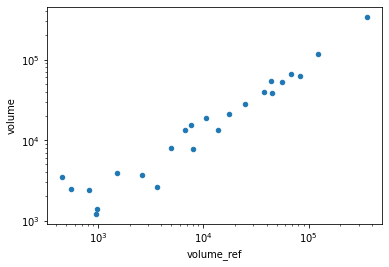

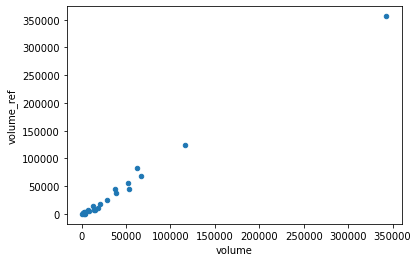

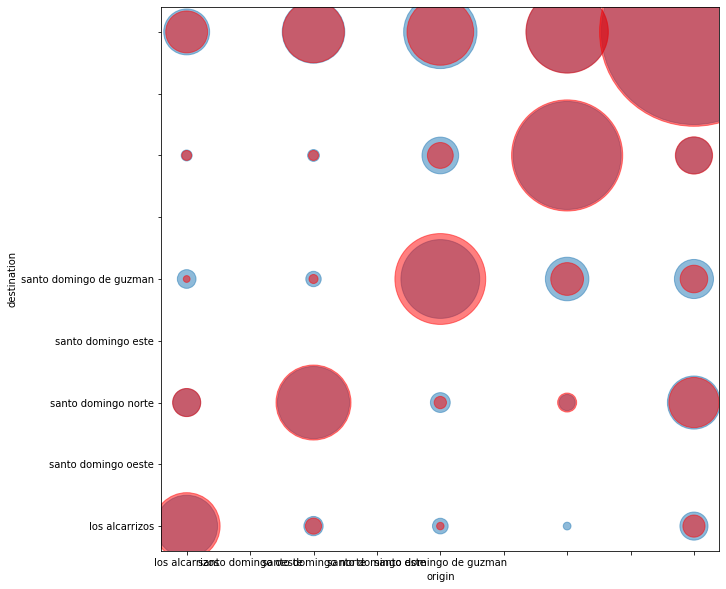

In [49]:
#df = df.loc[df['origin']!=df['destination']]
df = df.fillna(0)
z = sm.zones.copy()
z = z.loc[z['region'] == 'region ozama o metropolitana']
z = z.loc[z['municipio'].isin(
['los alcarrizos',
       'santo domingo oeste', 'santo domingo norte', 'santo domingo este',
       'santo domingo de guzman']
)]
df = pd.merge(df, z, left_on='origin', right_index=True)
df = pd.merge(df, z, left_on='destination', right_index=True, suffixes=['_origin', '_destination'])
df[['volume', 'volume_ref']].sum()
s = df.groupby(
    ['municipio_origin', 'municipio_destination']
)[['volume', 'volume_ref']].sum().astype(int)
s.loc[s['volume_ref']>0].dropna().plot(kind='scatter', y='volume', x='volume_ref', loglog=True)

s.plot(kind='scatter', x='volume', y='volume_ref', loglog=False)
print(s.corr())

s = s.unstack().fillna(0).stack()
r = s.reset_index()

d = dict(zip(['los alcarrizos',
       'santo domingo oeste', 'santo domingo norte', 'santo domingo este',
       'santo domingo de guzman'], list(range(5))))

r['origin'] = r['municipio_origin'].apply(lambda s: d[s])
r['destination'] = r['municipio_destination'].apply(lambda s: d[s])

ticks = ['test'] + list(d.keys())
scale = 10
power = 1
ax = r.plot(kind='scatter', x='origin', y='destination', s=np.power(r['volume']/scale, power), alpha=0.5, figsize=[10 ,10])
plot = r.plot(
    kind='scatter', x='origin', y='destination', s=np.power(r['volume_ref']/scale, power), alpha=0.5, color='red', ax = ax)
plot.set_xticklabels(ticks)
plot.set_yticklabels(ticks)

In [50]:
s.loc['santo domingo norte'].sum()

volume        135748
volume_ref    135751
dtype: int64

In [51]:
s.loc['santo domingo de guzman']

,volume,volume_ref
municipio_destination,,
los alcarrizos,7904,4902
santo domingo de guzman,343139,356346
santo domingo este,13389,13897
santo domingo norte,15285,7606
santo domingo oeste,28235,25203


In [52]:
od['volume_ref'] = od['peso_individual']

In [53]:
sm.volumes['volume'].sum()

919887.9999999999

,volume,volume_ref
volume,1.000000,0.997254
volume_ref,0.997254,1.000000


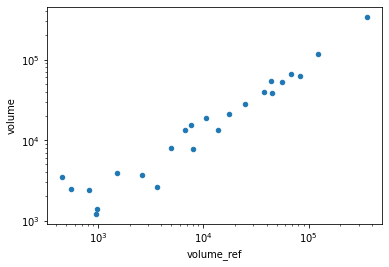

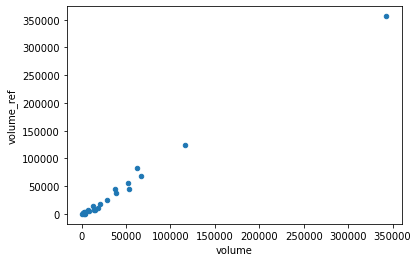

In [54]:
s = df.groupby(
    ['municipio_origin', 'municipio_destination']
)[['volume', 'volume_ref']].sum().astype(int)
s.loc[s['volume_ref']>0].dropna().plot(kind='scatter', y='volume', x='volume_ref', loglog=True)
#s = s.loc[s['volume']<500000]
s.plot(kind='scatter', x='volume', y='volume_ref', loglog=False)
s.corr()

In [55]:
from pandas import plotting

<AxesSubplot:ylabel='municipio_origin,municipio_destination'>

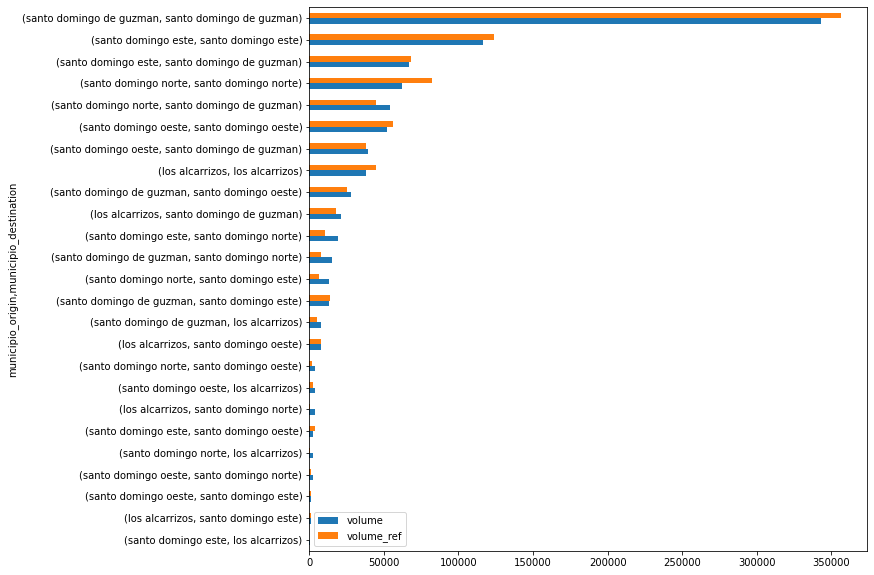

In [56]:
s.sort_values('volume').plot(kind='barh', figsize=[10, 10])

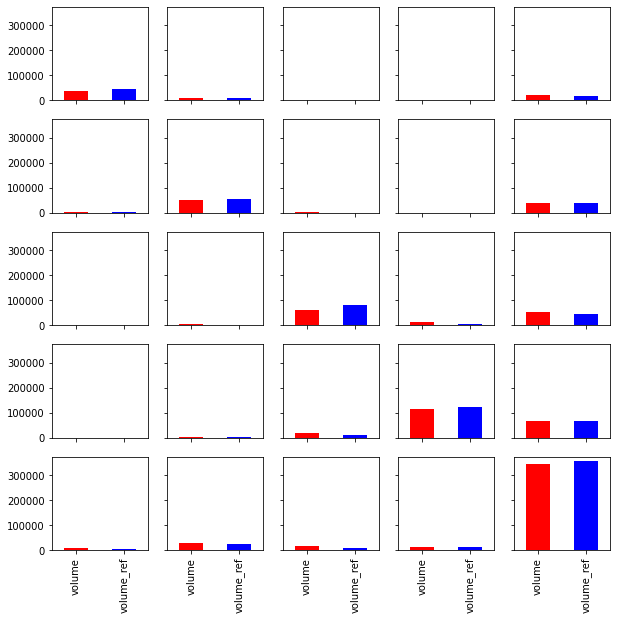

In [57]:
import matplotlib.pyplot as plt
fix, ax = plt.subplots(nrows=5, ncols=5, figsize=[10, 10], sharex=True, sharey=True)
for muna in d:
    for munb in d:
        s.loc[(muna ,munb)].plot(kind='bar', color=['red', 'blue'], ax=ax[d[muna]][d[munb]])

# disponibilidad carro

In [58]:
volumes = pd.merge(sm.volumes, sm.zones[['motorizacion']], left_on='origin', right_index=True)

In [59]:
volumes['car'] = volumes['motorizacion'] * volumes['volume']
volumes['nocar'] =  volumes['volume'] - volumes['car']

In [60]:
grouped = desplazamiento.groupby(['modo','origin', 'destination'])
mod = grouped['peso_individual'].sum().fillna(0).astype(int)
mod = mod.unstack('modo').fillna(0)

In [61]:
mod.rename(columns={'a_pie': 'survey_walk', 'carro': 'survey_car', 'pt': 'survey_pt'}, inplace=True)
mod.reset_index(inplace=True)

In [62]:
volumes = pd.merge(
    volumes, mod[['survey_walk', 'survey_car', 'survey_pt', 'origin', 'destination']], 
    on=['origin', 'destination'], how='left')

In [63]:
sm.volumes = volumes

# growth

In [64]:
sm.volumes[['car', 'nocar', 'survey_walk', 'survey_pt', 'survey_car']] *= hpm / ppm

In [65]:
sm.volumes = sm.volumes.fillna(0)

In [66]:
sm.euclidean = euclidean

In [67]:
set(sm.zones['provincia'])

{'distrito nacional', 'santo domingo'}

In [68]:
growth = pd.Series(
    {
        'distrito nacional': 1.006,
        'santo domingo': 1.016
    }

)

In [69]:
right = sm.zones[['provincia']]
right['growth'] = right['provincia'].apply(
    lambda p: {
        'distrito nacional': 1.006,
        'santo domingo': 1.016
    }[p]
)


In [70]:
sm.volumes['growth'] = sm.volumes['origin'].apply(lambda o: right['growth'].to_dict()[o])

In [71]:
ref_year = 2018
for year in range(2018, 2100):
    for segment in 'car', 'nocar':
        delta = year - ref_year
        sm.volumes[segment + str(year)] = sm.volumes[segment]  * np.power(sm.volumes['growth'], delta)      
sm.volumes

,origin,destination,volume,motorizacion,car,nocar,survey_walk,survey_car,survey_pt,growth,...,car2095,nocar2095,car2096,nocar2096,car2097,nocar2097,car2098,nocar2098,car2099,nocar2099
0,zone_1,zone_1,3.706954e+03,0.545,6.950091e+02,5.802369e+02,583.104657,0.0,0.000000,1.006,...,1.101628e+03,9.197079e+02,1.108238e+03,9.252261e+02,1.114887e+03,9.307775e+02,1.121577e+03,9.363621e+02,1.128306e+03,9.419803e+02
1,zone_1,zone_10,1.362500e+01,0.545,2.554523e+00,2.132675e+00,0.000000,0.0,0.000000,1.006,...,4.049061e+00,3.380409e+00,4.073356e+00,3.400691e+00,4.097796e+00,3.421096e+00,4.122382e+00,3.441622e+00,4.147117e+00,3.462272e+00
2,zone_1,zone_101,2.021907e-15,0.545,3.790831e-16,3.164822e-16,0.000000,0.0,0.000000,1.006,...,6.008678e-16,5.016419e-16,6.044730e-16,5.046518e-16,6.080998e-16,5.076797e-16,6.117484e-16,5.107257e-16,6.154189e-16,5.137901e-16
3,zone_1,zone_102,1.753460e+01,0.545,3.287525e+00,2.744631e+00,0.000000,0.0,0.000000,1.006,...,5.210910e+00,4.350393e+00,5.242176e+00,4.376495e+00,5.273629e+00,4.402754e+00,5.305271e+00,4.429171e+00,5.337102e+00,4.455746e+00
4,zone_1,zone_103,2.372934e+00,0.545,4.448965e-01,3.714274e-01,0.000000,0.0,0.000000,1.006,...,7.051857e-01,5.887330e-01,7.094169e-01,5.922654e-01,7.136734e-01,5.958190e-01,7.179554e-01,5.993940e-01,7.222631e-01,6.029903e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15620,zone_98,zone_94,6.599549e+01,0.625,1.418963e+01,8.513779e+00,0.000000,0.0,0.000000,1.016,...,4.817111e+01,2.890266e+01,4.894184e+01,2.936511e+01,4.972491e+01,2.983495e+01,5.052051e+01,3.031231e+01,5.132884e+01,3.079730e+01
15621,zone_98,zone_95,9.594952e+01,0.625,2.063002e+01,1.237801e+01,0.000000,0.0,0.000000,1.016,...,7.003500e+01,4.202100e+01,7.115556e+01,4.269334e+01,7.229405e+01,4.337643e+01,7.345076e+01,4.407046e+01,7.462597e+01,4.477558e+01
15622,zone_98,zone_96,8.224456e+01,0.625,1.768333e+01,1.061000e+01,0.000000,0.0,58.482473,1.016,...,6.003154e+01,3.601892e+01,6.099205e+01,3.659523e+01,6.196792e+01,3.718075e+01,6.295941e+01,3.777564e+01,6.396676e+01,3.838005e+01
15623,zone_98,zone_97,1.263094e+02,0.625,2.715766e+01,1.629460e+01,0.000000,0.0,119.717062,1.016,...,9.219510e+01,5.531706e+01,9.367022e+01,5.620213e+01,9.516894e+01,5.710137e+01,9.669165e+01,5.801499e+01,9.823871e+01,5.894323e+01


In [228]:
import os
try: 
    os.mkdir(quetzal_path + 'model/transport')
except FileExistsError:
    pass
sm.to_zip(quetzal_path + 'model/transport/distribution.zip')

jsons: 100%|███████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 18.56it/s]


In [73]:
work_path = r'../../../'
input_folder= work_path + r'quetzal_santo_domingo/inputs/'
sm.volumes.to_csv(input_folder + 'data/od_matrix.csv')